## Load the data

In [1]:
import json
from tqdm import tqdm
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

import torch

from s4hci.utils.data_handling import load_adi_data, save_as_fits
from s4hci.models.psf_subtraction import S4
from s4hci.models.noise import S4Noise

from applefy.utils.fake_planets import add_fake_planets

In [2]:
print("Loading data ... ", end='')
science_data, raw_angles, raw_psf_template_data = \
    load_adi_data("/fast/mbonse/s4/30_data/EpsEri_0100_C-0656-A.hdf5",
                  data_tag="13_object_final",
                  psf_template_tag="10_psf",
                  para_tag="header_13_object_final/PARANG") 

psf_template_data = np.mean(raw_psf_template_data, axis=0)
print("[DONE]")

Loading data ... [DONE]


In [3]:
# Background subtraction
psf_template_data = psf_template_data - np.min(psf_template_data)

## Add a fake planet

In [4]:
config_file = "/fast/mbonse/s4/30_data/0100_C-0656-A/configs_cgrid/exp_ID_0117a.json"

In [5]:
with open(config_file) as json_file:
    fake_planet_config = json.load(json_file)

In [6]:
data_with_fake_planet = science_data

In [7]:
data_with_fake_planet = add_fake_planets(
    input_stack=science_data,
    psf_template=psf_template_data,
    parang=raw_angles,
    dit_psf_template=0.004256,
    dit_science=0.08,
    experiment_config=fake_planet_config,
    scaling_factor=1.0)

# Create the S4 model

In [8]:
s4_model = S4(
    data_cube=data_with_fake_planet,
    parang=raw_angles,
    psf_template=psf_template_data,
    noise_noise_cut_radius_psf=4.0,
    noise_mask_radius=5.5,
    device=0,
    noise_lambda_init=1e3,
    planet_convolve_second=True,
    planet_use_up_sample=1,
    work_dir="/fast/mbonse/s4/70_results/02_fine_tuning/s4_full_model_test/",
    verbose=True)

Creating right reason mask ... [DONE]


## 1. Find the right lambda

In [9]:
lambdas = np.logspace(1, 8, 200)

In [17]:
all_results, best_lambda = s4_model.validate_lambdas_noise(
    num_separations=5,
    lambdas=np.logspace(1, 8, 200),
    num_test_positions=10,
    test_size=0.3,
    approx_svd=5000)

Compute validation positions for separation 8.833333333333334 ...
Setup training data for separation 8.833333333333334 ...
Build normalization frames ... [DONE]
Compute betas for separation 8.833333333333334 ...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:55<00:00,  5.53s/it]


Re-mask betas for separation 8.833333333333334 ...
Compute validation errors for separation 8.833333333333334 ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 739.70it/s]


Compute validation positions for separation 17.666666666666668 ...
Setup training data for separation 17.666666666666668 ...
Build normalization frames ... [DONE]
Compute betas for separation 17.666666666666668 ...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:55<00:00,  5.55s/it]


Re-mask betas for separation 17.666666666666668 ...
Compute validation errors for separation 17.666666666666668 ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 819.25it/s]


Compute validation positions for separation 26.5 ...
Setup training data for separation 26.5 ...
Build normalization frames ... [DONE]
Compute betas for separation 26.5 ...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:55<00:00,  5.53s/it]


Re-mask betas for separation 26.5 ...
Compute validation errors for separation 26.5 ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 819.16it/s]


Compute validation positions for separation 35.333333333333336 ...
Setup training data for separation 35.333333333333336 ...
Build normalization frames ... [DONE]
Compute betas for separation 35.333333333333336 ...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:55<00:00,  5.53s/it]


Re-mask betas for separation 35.333333333333336 ...
Compute validation errors for separation 35.333333333333336 ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 778.05it/s]


Compute validation positions for separation 44.16666666666667 ...
Setup training data for separation 44.16666666666667 ...
Build normalization frames ... [DONE]
Compute betas for separation 44.16666666666667 ...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:55<00:00,  5.56s/it]


Re-mask betas for separation 44.16666666666667 ...
Compute validation errors for separation 44.16666666666667 ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 796.31it/s]


Recommended Lambda = 18679.14
Make sure to check if the tested range of lambda values is covering the global minimum!


In [21]:
merged_results = np.array([i for i in all_results.values()])
median_result = np.median(merged_results, axis=0)

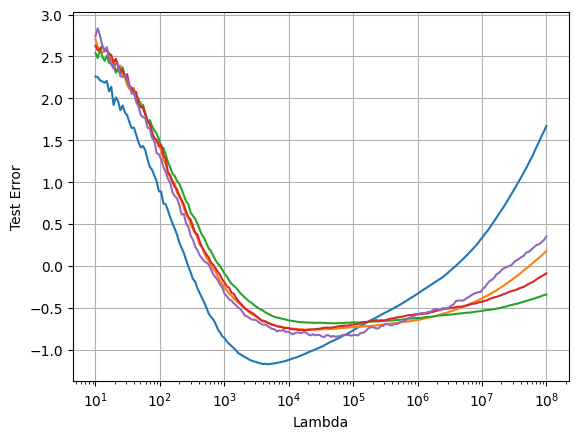

In [28]:
plt.plot(lambdas, np.array(merged_results).T)
plt.xlabel("Lambda")
plt.ylabel("Test Error")
plt.xscale("log")
plt.grid()

## 2. Find the closed for solution

In [29]:
s4_model.find_closed_form_noise_model()

Build normalization frames ... [DONE]
Fitting ... 

  3%|████▊                                                                                                                                                            | 341/11449 [01:56<1:03:10,  2.93it/s]


KeyboardInterrupt: 

In [9]:
# Load a previous model
save_path_final = Path("/fast/mbonse/s4/70_results/02_fine_tuning/"
                       "implementation_tests/test_model_trained_fp64.pkl")

s4_noise = S4Noise.load(save_path_final)

Creating right reason mask ... [DONE]


In [10]:
s4_noise = s4_noise.float()

In [11]:
s4_model.noise_model = s4_noise

## 3. Fine tune the model

In [12]:
residual_before_fine_tuning = s4_model.compute_residual(account_for_planet=False)

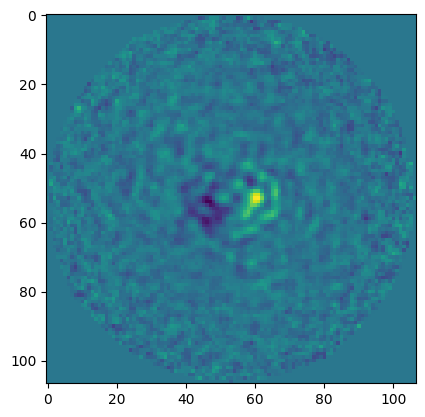

In [13]:
plt.imshow(residual_before_fine_tuning)

In [14]:
s4_model.fine_tune_model_with_planet(
    100,
    learning_rate_planet=1e-3,
    learning_rate_noise=1e-6,
    fine_tune_noise_model=True,
    rotation_grid_down_sample=10,
    upload_rotation_grid=True)

  0%|          | 0/100 [00:00<?, ?it/s]

In [15]:
residual_with_planet_model = s4_model.compute_residual(account_for_planet=True)

In [16]:
residual_no_planet_model = s4_model.compute_residual(account_for_planet=False)

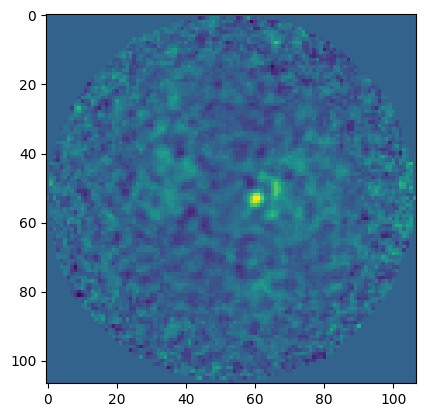

In [17]:
plt.imshow(residual_with_planet_model)

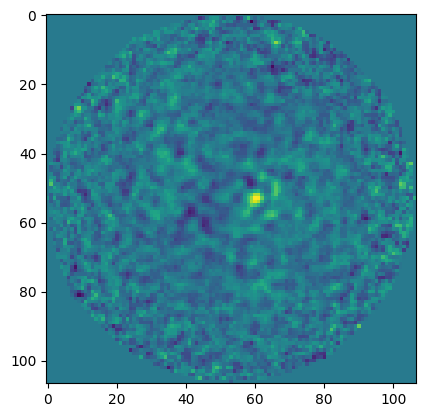

In [18]:
plt.imshow(residual_no_planet_model)

In [19]:
save_as_fits(residual_with_planet_model, 
             s4_model.residuals_dir / Path("Residual_with_planet_model.fits"),
             overwrite=True)
save_as_fits(residual_no_planet_model, 
             s4_model.residuals_dir / Path("Residual_no_planet_model.fits"),
             overwrite=True)

In [20]:
save_as_fits(residual_before_fine_tuning, s4_model.residuals_dir / Path("Residual_before_fine_tuning.fits"))